In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl

import random
from numpy.linalg import svd, matrix_rank, norm
from sklearn import linear_model
import pickle

In [83]:
def hsvt(X, rank): 
    """
    Input:
        X: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    return np.dot(u*s, v)

def hsvt_df(X, rank): 
    """
    Input:
        X: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    vals = (np.dot(u*s, v))
    return pd.DataFrame(vals, index = X.index, columns = X.columns)

def matrixFromSVD(sk, Uk, Vk, probability=1.0):
    # Jehangir's
    return (1.0/probability) * np.dot(Uk, np.dot(np.diag(sk), Vk.T))

def hsvt_new(X, rank):
    Uk, sk, Vk = np.linalg.svd(X, full_matrices=False)
    Vk = Vk.T
    sk[rank:].fill(0)
    output = matrixFromSVD(sk, Uk, Vk, probability=1.0)
    return output

def hsvt_new_df(df, rank):
    Uk, sk, Vk = np.linalg.svd(df.values, full_matrices=False)
    Vk = Vk.T
    sk[rank:].fill(0)
    output = matrixFromSVD(sk, Uk, Vk, probability=1.0)
    return pd.DataFrame(output, index=df.index, columns=df.columns)

def get_preint_data(X, T0, T, K):
    """
    Input:
        X: N x KT matrix
        T0: pre-int period
        T: total period
        K: number of metrics
    
    Output:
        X_pre: N x KT0 matrix
    """
    X_pre = np.array([])
    for k in range(K): 
        if X.ndim > 1:
            X_temp = X[:, k*T:k*T + T0]
        else:
            X_temp = X[k*T:k*T + T0]
        X_pre = np.hstack([X_pre, X_temp]) if X_pre.size else X_temp
    return X_pre

def get_postint_data(X, T0, T, K):
    """
    Input:
        X: N x KT matrix
        T0: pre-int period
        T: total period
        K: number of metrics
    
    Output:
        X_post: N x K(T-T0) matrix
    """
    X_post = np.array([])
    for k in range(K): 
        if X.ndim > 1:
            X_temp = X[:, k*T+T0:(k+1)*T]
        else:
            X_temp = X[k*T+T0:(k+1)*T]
        X_post = np.hstack([X_post, X_temp]) if X_post.size else X_temp
    return X_post


def pre_post_split(y, T0, T, num_metrics):
        y_pre = get_preint_data(y, T0, T, num_metrics)
        y_post = get_postint_data(y, T0, T, num_metrics)
        return y_pre, y_post


def approximate_rank(X, t=99):
    """
    Input:
        X: matrix of interest
        t: an energy threshold. Default (99%)
        
    Output:
        r: approximate rank of Z
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    total_energy = (100*(s**2).cumsum()/(s**2).sum())
    r = list((total_energy>t)).index(True)+1
    return r

def relative_spectrum(X):
    """
    Input:
        X: matrix of interest
        
    Output:
        list: with % of spectrum explained by first eigenvalues of Z
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    return (s**2)/((s**2).sum())

def donor_prep(X, t):
    """
    Input:
        X: matrix of interest
        t: threshold
    
    Output:
        thresholded matrix
    """
    r = approximate_rank(X, thresh)
    print("{} SV = {}% of energy".format(r, t))
    X_hsvt = hsvt(X, r)
    return np.abs(X_hsvt.round())

def mse(y, y_pred):
    return np.sum((y - y_pred) ** 2) / len(y)

def rmse(y, y_pred):
    return np.sqrt(mse(y,y_pred))

def mape(y, y_pred):
    mask = (y != 0)
    return np.mean(np.abs((y - y_pred)[mask] / y[mask]))

In [3]:
class mRSC:
    def __init__(self, donor, target, metrics, donor_ids, target_ids, T_0s, singvals): 
        """
        donor = (df) donor matrix
        target = (df) target_matrix
        metrics = (list) list of metrics in donor/target matrix
        donor_ids = (list) donor ids
        target_ids = (list) target_ids
        T_0s = (list)
        singvals = (int) the number of singular values to keep; 0 if no HSVT
        """
        if (singvals != 0):
            self.donor = hsvt_new_df(donor, singvals)
        else:
            self.donor = donor
        self.target = target
        self.metrics = metrics
        self.donor_ids = donor_ids
        self.target_ids = target_ids
        self.num_k = len(self.metrics)
        self.T = int(self.target.shape[1]/self.num_k)
        self.T_0s = T_0s
        self.singvals = singvals
        
        """
        results are in a list of df's. df's.
        list[0] corresponds to the first T_0
        df's have target ids as index
        """
        self.pred = [pd.DataFrame(columns=self.target.columns, index=self.target.index)] * len(T_0s)
        self.betas = [pd.DataFrame(columns=self.donor.index, index=self.target.index)] * len(T_0s)
#         self.mse_all = [pd.DataFrame(columns=range(num_k), index=self.target.index)] * len(T_0s)
    
    def learn(self, target_id, T_0, method='lr'):
        # treatment unit
        y = self.target[self.target.index == target_id]
        y = y.values.flatten()

        # pre-intervention
        donor_pre = get_preint_data(self.donor.values, T_0, self.T, self.num_k)
        y_pre = get_preint_data(y, T_0, self.T, self.num_k)

        if (method == 'lr'):
            # linear regression
            regr = linear_model.LinearRegression(fit_intercept=False)
#             regr.n_jobs = -1
            regr.fit(donor_pre.T, y_pre)
            beta = regr.coef_
            
        elif (method == 'pinv'):
            beta = np.linalg.pinv(donor_pre.T).dot(y_pre)
            
        else:
            raise ValueError("Invalid method.")
        
        i = np.where(np.array(self.T_0s) == T_0)[0][0]
        
        # beta
        updated_beta = self.betas[i].copy()
        updated_beta[updated_beta.index == target_id] = [beta]
        self.betas[i] = updated_beta
        
        # prediction
        prediction = self.donor.T.dot(beta).values
        updated_pred = self.pred[i].copy()
        updated_pred[updated_pred.index == target_id] = [prediction]
        self.pred[i]= updated_pred
        
#         # mse
#         mse_list = []
#         for k in range(self.num_k):
#             val = mse(y[self.T*k:self.T*(k+1)], prediction[self.T*k:self.T*(k+1)])
#             mse_list.append(val)
#         updated_mse = self.mse_all[i].copy()
#         updated_mse[updated_mse.index == target_id] = [mse]
#         self.mse_all[i] = updated_mse

In [4]:
def getData(pre1, pre2, metrics, game_ids):
    """
        pre1 = (string) target or donor
        pre2 = (string) home or away
        metrics = (list) list of metrics
    """
    prefix = pre1+ "_" + pre2 + "_"
    df = pd.DataFrame()
    for i in range(len(metrics)):
        bucket = pd.read_pickle("../data/nba-hosoi/"+ prefix +metrics[i]+".pkl")
        df = pd.concat([df, bucket], axis = 1)
    df = df[df.index.isin(game_ids)]
    print("DataFrame size ", df.shape, "was created.")
    return df

# For Jehangir's Code
def getDataForGit(pre1, pre2, metrics, game_ids):
    """
        pre1 = (string) target or donor
        pre2 = (string) home or away
        metrics = (list) list of metrics
    """
    df_list = []
    prefix = pre1+ "_" + pre2 + "_"
    df = pd.DataFrame()
    for i in range(len(metrics)):
        df = pd.read_pickle("../data/nba-hosoi/"+ prefix +metrics[i]+".pkl")
        df = df.iloc[df.index.isin(game_ids)].T
        df = df.reset_index(drop=True)
        df_list.append(df)
    return df_list

def getDF(donor_list, target_list, target_id):
    # append the first column (target) before the donor dataframe
    num_k = len(donor_list)
    DF_list =[]
    for k in range(num_k):
        bucket = pd.concat([target_list[k][target_id], donor_list[k]], axis=1)
        DF_list.append(bucket)
    return DF_list

def DF_split(DF_list, T_0):
    # split train and test
    num_k = len(DF_list)
    DF_train_list =[]
    DF_test_list =[]
    for k in range(num_k):
        X = DF_list[k]
        train = X.iloc[:T_0,:]
        test = X.iloc[T_0:,:]
        DF_train_list.append(train)
        DF_test_list.append(test)
    return DF_train_list, DF_test_list



# Experiment 1
- Home/Away Separate
- Donor: 2013-2016, Target: 2017
- 5 metrics
- no HSVT

# Saeyoung's old code

In [172]:
""" Separte, with 5 Metrics, w/o HSVT """

""" construct the matrix """
"""
    Donor: 2013 - 2016 season
    Target: 2017 season
"""

# experiment prarams
train_pcts = [0.1, 0.25, 0.5, 0.75, 0.9]
freq = 15
T = int(12*60*4/freq + 1)
T_0s = [int(np.ceil(train_pct * T)) for train_pct in train_pcts]
singvals= 0
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))
metrics = ['points','assists', 'rebounds', 'bs', 'fouls']

# import data
donor_home = getData("donor", "home", metrics, donor_ids)
donor_away = getData("donor", "away", metrics, donor_ids)

target_home = getData("target", "home", metrics, target_ids)
target_away = getData("target", "away", metrics, target_ids)

""" lr """
# construct model
mRSC_home = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
# mRSC_away = mRSC(donor_away, target_away, metrics, donor_ids, target_ids, T_0s, singvals)

# run
for i in range(len(train_pcts)):
    T_0 = T_0s[i]
    print("start: ", str(i+1), " / 5")
    # for each game in target
    for target_id in target_ids[5:6]:
        mRSC_home.learn(target_id, T_0, method='lr')
#         mRSC_away.learn(target_id, T_0, method='lr')

""" pinv """
# construct model
mRSC_home_pinv = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
# mRSC_away_pinv = mRSC(donor_away, target_away, metrics, donor_ids, target_ids, T_0s, singvals)

# run
for i in range(len(train_pcts)):
    T_0 = T_0s[i]
    print("start: ", str(i+1), " / 5")
    # for each game in target
    for target_id in target_ids[5:6]:
        mRSC_home_pinv.learn(target_id, T_0, method='pinv')
#         mRSC_away_pinv.learn(target_id, T_0, method='pinv')

DataFrame size  (4738, 965) was created.
DataFrame size  (4738, 965) was created.
DataFrame size  (1179, 965) was created.
DataFrame size  (1179, 965) was created.
start:  1  / 5
start:  2  / 5
start:  3  / 5
start:  4  / 5
start:  5  / 5
start:  1  / 5
start:  2  / 5
start:  3  / 5
start:  4  / 5
start:  5  / 5


# Using Github Code

In [173]:
i=0 # intervention point of choice to compare

# experiment prarams
singvals = 99999
num_k = len(metrics)
relative_weights = [1.0] * len(T_0s)

# data prep
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))

donor_home_list = getDataForGit("donor", "home", metrics, donor_ids)
target_home_list = getDataForGit("target", "home", metrics, target_ids)

donor_away_list = getDataForGit("donor", "away", metrics, donor_ids)
target_away_list = getDataForGit("target", "away", metrics, target_ids)

# result
df_mse_home = pd.DataFrame(columns = ["Test MSE"])
df_pred_home = pd.DataFrame()
df_mse_away = pd.DataFrame(columns = ["Test MSE"])
df_pred_away = pd.DataFrame()

T_0 = T_0s[i]
for target_id in target_ids[5:6]:
    keySeriesLabel = target_id
    otherSeriesLabels = donor_ids.tolist()

    # combine target (first row) + doner matrix
    DF_home_list = getDF(donor_home_list, target_home_list, target_id)
    DF_away_list = getDF(donor_away_list, target_away_list, target_id)

    # train/test split
    DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     
    DF_away_train_list, DF_away_test_list = DF_split(DF_away_list, T_0)        

    # model
    mrscmodel = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    """ home """
    # fit
    mrscmodel.fit(DF_home_train_list)

    # predict
    combinedPredictionsArray = mrscmodel.predict(donor_home_list)

    # split the predictions for the metrics
    score_pred = combinedPredictionsArray[0]

    # compute MSE
    mrscMSE = np.mean((score_pred[T_0:] - DF_home_test_list[0][target_id])**2)

    df_mse_home = df_mse_home.append(pd.DataFrame(mrscMSE, index = [target_id], columns=["Test MSE"]))
    df_pred_home = df_pred_home.append(pd.DataFrame([score_pred], index = [target_id], columns=range(T)))
    
#     """ away """
#     # fit
#     mrscmodel.fit(DF_away_train_list)

#     # predict
#     combinedPredictionsArray = mrscmodel.predict(donor_away_list)

#     # split the predictions for the metrics
#     score_pred = combinedPredictionsArray[0]

#     # compute MSE
#     mrscMSE = np.mean((score_pred[T_0:] - DF_away_test_list[0][target_id])**2)

#     df_mse_away = df_mse_away.append(pd.DataFrame(mrscMSE, index = [target_id], columns=["Test MSE"]))
#     df_pred_away = df_pred_away.append(pd.DataFrame([score_pred], index = [target_id], columns=range(T)))

# Compare the result

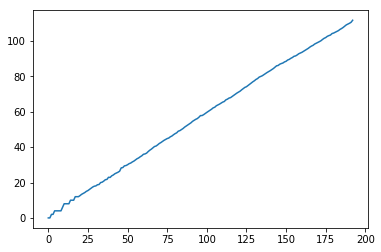

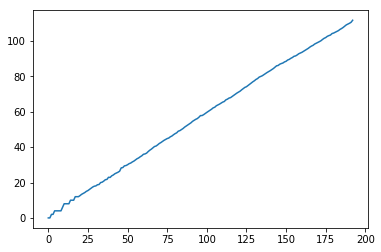

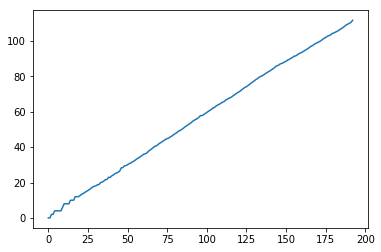

In [174]:
pred_lr = mRSC_home.pred[i].iloc[5:6,:193].values.flatten()
plt.plot(pred_lr)
plt.show()

pred_pinv = mRSC_home_pinv.pred[i].iloc[5:6,:193].values.flatten()
plt.plot(pred_pinv)
plt.show()

pred_git = df_pred_home.values.flatten()
plt.plot(pred_git)
plt.show()

In [175]:
print(np.mean(np.abs(pred_pinv - pred_lr)))
print(np.mean(np.abs(pred_pinv - pred_git)))
print(np.mean(np.abs(pred_lr - pred_git)))

1.278205893712336e-13
0.0062536605985521404
0.006253660598593952


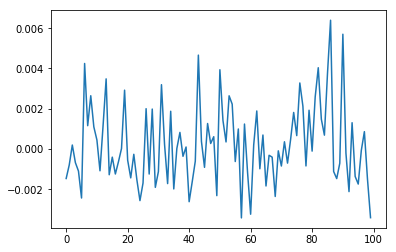

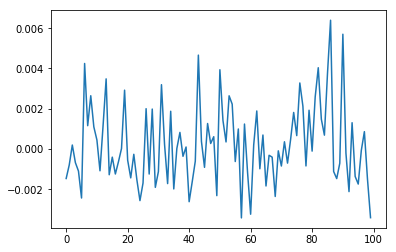

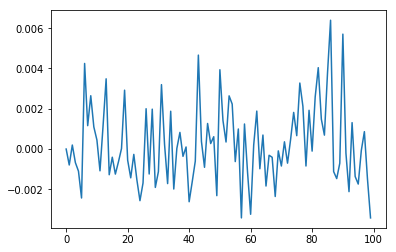

In [176]:
beta_lr = mRSC_home.betas[i].iloc[5:6,:].values.flatten()
plt.plot(beta_lr[:100])
plt.show()

beta_pinv = mRSC_home_pinv.betas[i].iloc[5:6,:].values.flatten()
plt.plot(beta_pinv[:100])
plt.show()

beta_git = mrscmodel.model.weights
plt.plot(beta_git[:100])
plt.show()

In [177]:
print(rmse(beta_pinv, beta_lr))
print(rmse(beta_pinv, beta_git))
print(rmse(beta_lr, beta_git))

1.17789102987e-17
2.14230698988e-05
2.14230698988e-05


In [178]:
# donor matrix seems to be the same
a = mrscmodel.model.matrix[:-1,:T_0]
b = mRSC_home.donor.iloc[:,:T_0]

rmse(a,b).mean()

1.958480824904682e-14

In [182]:
# target matrix seems to be the same
a = mrscmodel.model.matrix[-1,:T_0]
b = mRSC_home.target.iloc[5:6,:T_0].values
rmse(a,b).mean()

2.2687587548231676e-14

In [181]:
mrscmodel.model.matrix[-1,:T_0].round() == mRSC_home.target.iloc[5:6,:T_0].values

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]], dtype=bool)

In [191]:
mrscmodel.model.matrix.round()[-1,:T_0]

array([  0.,  -0.,   2.,   2.,   4.,   4.,   4.,   4.,   4.,   6.,   8.,
         8.,   8.,   8.,  10.,  10.,  10.,  12.,  12.,  12.])

In [189]:
mRSC_home.target.iloc[5:6,:T_0].values

array([[  0.,   0.,   2.,   2.,   4.,   4.,   4.,   4.,   4.,   6.,   8.,
          8.,   8.,   8.,  10.,  10.,  10.,  12.,  12.,  12.]])


# Experiment 2
- Home/Away Separate
- Donor: 2013-2016, Target: 2017
- 5 metrics
- HSVT = 2

# Saeyoung's old code

In [193]:
""" Separte, with 5 Metrics, HSVT = 2, Method = lr """

""" construct the matrix """
"""
    Donor: 2013 - 2016 season
    Target: 2017 season
"""

# experiment prarams
train_pcts = [0.1, 0.25, 0.5, 0.75, 0.9]
freq = 15
T = int(12*60*4/freq + 1)
T_0s = [int(np.ceil(train_pct * T)) for train_pct in train_pcts]
singvals = 1
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))
metrics = ['points','assists', 'rebounds', 'bs', 'fouls']
num_k = len(metrics)

# import data
donor_home = getData("donor", "home", metrics, donor_ids)
donor_away = getData("donor", "away", metrics, donor_ids)

target_home = getData("target", "home", metrics, target_ids)
target_away = getData("target", "away", metrics, target_ids)

# construct model
mRSC_home = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
mRSC_away = mRSC(donor_away, target_away, metrics, donor_ids, target_ids, T_0s, singvals)

# run
for i in range(5):
    T_0 = T_0s[i]
    print("start: ", str(i+1), " / 5")
    # for each game in target
    for target_id in target_ids[5:6]:
        mRSC_home.learn(target_id, T_0, method='lr')
        mRSC_away.learn(target_id, T_0, method='lr')


""" Separte, with 5 Metrics, HSVT = 2, Method = pinv """
# construct model
mRSC_home_pinv = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
mRSC_away_pinv = mRSC(donor_away, target_away, metrics, donor_ids, target_ids, T_0s, singvals)

# run
for i in range(5):
    T_0 = T_0s[i]
    print("start: ", str(i+1), " / 5")
    # for each game in target
    for target_id in target_ids[5:6]:
        mRSC_home_pinv.learn(target_id, T_0, method='pinv')
        mRSC_away_pinv.learn(target_id, T_0, method='pinv')

DataFrame size  (4738, 965) was created.
DataFrame size  (4738, 965) was created.
DataFrame size  (1179, 965) was created.
DataFrame size  (1179, 965) was created.
start:  1  / 5
start:  2  / 5
start:  3  / 5
start:  4  / 5
start:  5  / 5
start:  1  / 5
start:  2  / 5
start:  3  / 5
start:  4  / 5
start:  5  / 5


# Jehangir's Github Code

In [194]:
# experiment prarams
relative_weights = [1.0] * len(T_0s)

# data prep
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))

donor_home_list = getDataForGit("donor", "home", metrics, donor_ids)
target_home_list = getDataForGit("target", "home", metrics, target_ids)

donor_away_list = getDataForGit("donor", "away", metrics, donor_ids)
target_away_list = getDataForGit("target", "away", metrics, target_ids)

In [195]:
i=0
T_0 = T_0s[i]
    
# result
df_mse_home = pd.DataFrame(columns = ["Test MSE"])
df_pred_home = pd.DataFrame()
df_mse_away = pd.DataFrame(columns = ["Test MSE"])
df_pred_away = pd.DataFrame()

for target_id in target_ids[5:6]:
    keySeriesLabel = target_id
    otherSeriesLabels = donor_ids.tolist()

    # combine target (first row) + doner matrix
    DF_home_list = getDF(donor_home_list, target_home_list, target_id)
    DF_away_list = getDF(donor_away_list, target_away_list, target_id)

    # train/test split
    DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     
    DF_away_train_list, DF_away_test_list = DF_split(DF_away_list, T_0)        

    # model
    mrscmodel = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    """ home """
    # fit
    mrscmodel.fit(DF_home_train_list)

    # predict
    combinedPredictionsArray = mrscmodel.predict(donor_home_list)

    # split the predictions for the metrics
    score_pred = combinedPredictionsArray[0]

    # compute MSE
    mrscMSE = np.mean((score_pred[T_0:] - DF_home_test_list[0][target_id])**2)

    df_mse_home = df_mse_home.append(pd.DataFrame(mrscMSE, index = [target_id], columns=["Test MSE"]))
    df_pred_home = df_pred_home.append(pd.DataFrame([score_pred], index = [target_id], columns=range(T)))
    
#     """ away """
#     # fit
#     mrscmodel.fit(DF_away_train_list)

#     # predict
#     combinedPredictionsArray = mrscmodel.predict(donor_away_list)

#     # split the predictions for the metrics
#     score_pred = combinedPredictionsArray[0]

#     # compute MSE
#     mrscMSE = np.mean((score_pred[T_0:] - DF_away_test_list[0][target_id])**2)

#     df_mse_away = df_mse_away.append(pd.DataFrame(mrscMSE, index = [target_id], columns=["Test MSE"]))
#     df_pred_away = df_pred_away.append(pd.DataFrame([score_pred], index = [target_id], columns=range(T)))

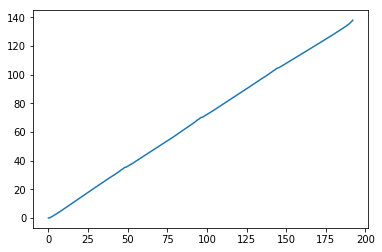

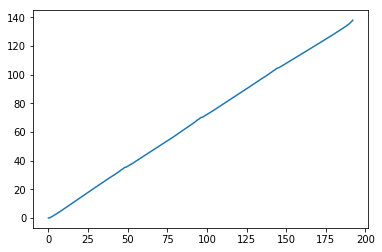

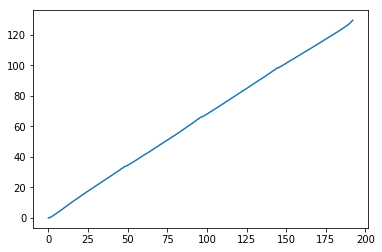

In [196]:
pred_lr = mRSC_home.pred[i].iloc[5:6,:193].values.flatten()
plt.plot(pred_lr)
plt.show()

pred_pinv = mRSC_home_pinv.pred[i].iloc[5:6,:193].values.flatten()
plt.plot(pred_pinv)
plt.show()

pred_git = df_pred_home.values.flatten()
plt.plot(pred_git)
plt.show()

In [137]:
print(rmse(pred_pinv, pred_lr))
print(rmse(pred_pinv, pred_git))
print(rmse(pred_lr, pred_git))

2.8852523735e-13
0.437081442301
0.437081442301


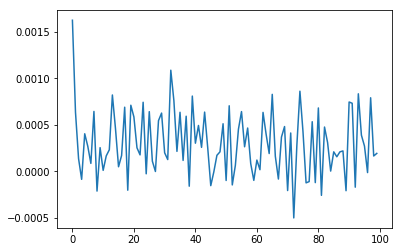

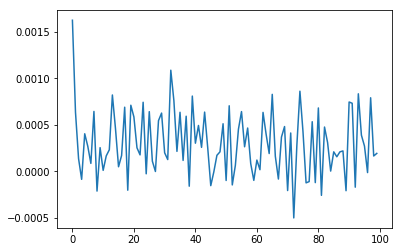

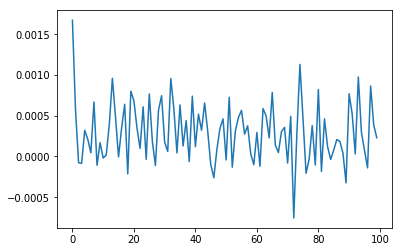

In [138]:
beta_lr = mRSC_home.betas[i].iloc[5:6,:].values.flatten()
plt.plot(beta_lr[:100])
plt.show()

beta_pinv = mRSC_home_pinv.betas[i].iloc[5:6,:].values.flatten()
plt.plot(beta_pinv[:100])
plt.show()

beta_git = mrscmodel.model.weights
plt.plot(beta_git[:100])
plt.show()

In [141]:
print(rmse(beta_pinv, beta_lr))
print(rmse(beta_pinv, beta_git))
print(rmse(beta_lr, beta_git))

1.83240785672e-18
0.000102570223161
0.000102570223161


In [236]:
# donor matrix
a = mrscmodel.model.matrix[:-1,:T_0]
b = mRSC_home.donor.iloc[:,:T_0]

rmse(a,b).mean()

10.367798946248199

In [237]:
# target matrix
a = mrscmodel.model.matrix[-1,:T_0]
b = mRSC_home.target.iloc[5:6,:T_0].values
rmse(a,b).mean()

15.139563657925731

In [125]:
mrscmodel.model.matrix

(4739, 485)

In [144]:
mrscmodel.model.matrix[-1,:T_0].round(2)

array([   0.  ,    0.18,    0.79,    1.32,    1.98,    2.61,    3.27,
          3.89,    4.55,    5.22,    5.9 ,    6.61,    7.28,    7.93,
          8.65,    9.31,   10.01,   10.72,   11.4 ,   12.1 ,   12.79,
         13.45,   14.17,   14.83,   15.53,   16.22,   16.85,   17.54,
         18.17,   18.75,   19.42,   20.06,   20.69,   21.29,   21.95,
         22.57,   23.21,   23.8 ,   24.38,   24.96,   25.53,   26.14,
         26.74,   27.34,   27.98,   28.6 ,   29.28,   29.71,   30.38,
         30.56,   30.99,   31.51,   32.01,   32.46,   33.02,   33.49,
         34.03,   34.56,   35.08,   35.66,   36.15,   36.66,   37.14,
         37.64,   38.23,   38.73,   39.27,   39.82,   40.35,   40.95,
         41.54,   42.06,   42.63,   43.15,   43.71,   44.25,   44.77,
         45.29,   45.9 ,   46.46,   47.02,   47.61,   48.2 ,   48.79,
         49.41,   49.99,   50.64,   51.22,   51.86,   52.46,   53.11,
         53.75,   54.44,   55.14,   55.88,   56.37,   57.24,   57.38,
         57.88,   58

In [145]:
mRSC_home.target.iloc[5:6,:T_0].values

array([[   0.,    0.,    2.,    2.,    4.,    4.,    4.,    4.,    4.,
           6.,    8.,    8.,    8.,    8.,   10.,   10.,   10.,   12.,
          12.,   12.,   14.,   14.,   16.,   16.,   16.,   16.,   16.,
          16.,   18.,   18.,   18.,   21.,   21.,   23.,   23.,   23.,
          23.,   23.,   25.,   25.,   25.,   25.,   25.,   25.,   25.,
          28.,   30.,   30.,   32.,   32.,   32.,   34.,   34.,   34.,
          34.,   34.,   34.,   34.,   36.,   36.,   36.,   36.,   36.,
          36.,   36.,   38.,   38.,   38.,   40.,   40.,   40.,   43.,
          45.,   46.,   46.,   46.,   46.,   46.,   46.,   46.,   46.,
          48.,   48.,   48.,   50.,   50.,   50.,   50.,   50.,   50.,
          52.,   52.,   54.,   54.,   56.,   56.,   56.,   56.,   58.,
          58.,   58.,   58.,   58.,   61.,   61.,   61.,   61.,   61.,
          63.,   65.,   65.,   67.,   67.,   69.,   69.,   72.,   72.,
          72.,   72.,   72.,   72.,   72.,   72.,   75.,   75.,   79.,
      

In [171]:
np.round(mrscmodel.model.matrix[:,:T_0])

array([[   0.,    0.,    1., ...,   88.,   88.,   88.],
       [   0.,    0.,    0., ...,   91.,   92.,   92.],
       [  -0.,    0.,    1., ...,   93.,   94.,   94.],
       ..., 
       [   0.,    0.,    1., ...,  106.,  106.,  107.],
       [  -0.,    0.,    1., ...,   96.,   97.,   97.],
       [   0.,    0.,    1., ...,  107.,  107.,  108.]])

In [157]:
mRSC_home.donor.iloc[:,:T_0]

,1970-01-01 00:00:00,1970-01-01 00:00:15,1970-01-01 00:00:30,1970-01-01 00:00:45,1970-01-01 00:01:00,1970-01-01 00:01:15,1970-01-01 00:01:30,1970-01-01 00:01:45,1970-01-01 00:02:00,1970-01-01 00:02:15,...,1970-01-01 00:41:00,1970-01-01 00:41:15,1970-01-01 00:41:30,1970-01-01 00:41:45,1970-01-01 00:42:00,1970-01-01 00:42:15,1970-01-01 00:42:30,1970-01-01 00:42:45,1970-01-01 00:43:00,1970-01-01 00:43:15
nbaId,,,,,,,,,,,,,,,,,,,,,
21300001,2.706712e-14,0.175788,0.758668,1.161861,1.838475,2.389194,2.945357,3.390221,3.953484,4.542669,...,84.084704,84.840778,85.550328,86.184922,86.891867,87.464801,88.151259,88.856369,89.433969,90.032771
21300002,2.486673e-15,0.073818,0.331418,0.573597,0.894028,1.223989,1.550517,1.876142,2.227986,2.507038,...,88.285204,88.716543,89.150457,89.554379,89.993479,90.385259,90.774940,91.242990,91.703958,92.106507
21300003,-5.439442e-16,0.168119,0.716738,1.244653,1.810614,2.378215,2.982406,3.586697,4.229556,4.866491,...,93.299752,93.969371,94.626162,95.268802,95.934443,96.567223,97.180276,97.806605,98.431995,99.086524
21300004,-5.814018e-15,0.073795,0.367863,0.785642,1.143295,1.510165,1.967799,2.415890,2.839092,3.242819,...,82.637460,82.992995,83.391962,83.777401,84.185339,84.587129,84.932228,85.308477,85.759974,86.136338
21300006,4.737694e-15,0.072379,0.328571,0.682386,1.009893,1.384077,1.772519,2.072168,2.479624,2.892322,...,79.651921,80.000182,80.368701,80.778130,81.141069,81.495497,81.819749,82.186169,82.504246,82.816174
21300007,3.200985e-15,0.136169,0.637825,1.160365,1.715373,2.264065,2.837090,3.357367,3.983785,4.597804,...,93.645930,94.250615,94.835371,95.444781,96.042293,96.598948,97.162107,97.755682,98.291217,98.872658
21300008,4.294252e-15,0.058986,0.341888,0.778450,1.159207,1.579592,1.990152,2.309881,2.762561,3.204333,...,76.846309,77.090569,77.421738,77.807033,78.081787,78.379107,78.695003,79.029299,79.300488,79.561145
21300009,6.444150e-15,0.063234,0.355182,0.653297,1.047160,1.361555,1.740037,2.058348,2.421592,2.743762,...,77.216623,77.673534,78.104390,78.509995,78.976528,79.363490,79.771406,80.241986,80.688261,81.094368
21300010,-5.240417e-15,0.164445,0.760815,1.468125,2.065254,2.708641,3.440852,4.178380,4.898691,5.662208,...,91.222665,91.708965,92.220612,92.735292,93.255801,93.768829,94.244408,94.695825,95.217118,95.734147


In [227]:
singvals = 2

target_id = target_ids[5]

keySeriesLabel = target_id
otherSeriesLabels = donor_ids.tolist()

# combine target (first row) + doner matrix
DF_home_list = getDF(donor_home_list, target_home_list, target_id)
DF_away_list = getDF(donor_away_list, target_away_list, target_id)

"""first model with T_0 = 20"""
T_0 = 20
# train/test split
DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     

# model
mrscmodel = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel.fit(DF_home_train_list)

"""second model with T_0 = 49"""
T_0 = 49
# train/test split
DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     

# model
mrscmodel_1 = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel_1.fit(DF_home_train_list)

# HSVT comparison

In [279]:
def hsvt(X, rank): 
    """
    Input:
        X: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    return np.dot(u*s, v)

def hsvt_df(X, rank): 
    """
    Input:
        X: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    vals = (np.dot(u*s, v))
    return pd.DataFrame(vals, index = X.index, columns = X.columns)

def matrixFromSVD(sk, Uk, Vk, probability=1.0):
    return (1.0/probability) * np.dot(Uk, np.dot(np.diag(sk), Vk.T))

def hsvt_new(X, rank):
    Uk, sk, Vk = np.linalg.svd(X, full_matrices=False)
    Vk = Vk.T
    sk[rank:].fill(0)
    output = matrixFromSVD(sk, Uk, Vk, probability=1.0)
    return output

def hsvt_new_df(df, rank):
    Uk, sk, Vk = np.linalg.svd(df.values, full_matrices=False)
    Vk = Vk.T
    sk[rank:].fill(0)
    output = matrixFromSVD(sk, Uk, Vk, probability=1.0)
    return pd.DataFrame(output, index=df.index, columns=df.columns)

In [257]:
mat, rank

(array([[ 0.209472  ,  0.00398113,  0.13006567,  0.02159573],
        [ 0.12718624,  0.25709967,  0.21606452,  0.15140834],
        [ 0.89551319,  0.12790539,  0.69026415,  0.63622093],
        [ 0.15439447,  0.89081125,  0.07489262,  0.88909662],
        [ 0.4576164 ,  0.9400423 ,  0.46718616,  0.0391289 ]]), 2)

In [271]:
df.index = ["a","b","c","d", "e"]
df

,0,1,2,3
a,0.209472,0.003981,0.130066,0.021596
b,0.127186,0.257100,0.216065,0.151408
c,0.895513,0.127905,0.690264,0.636221
d,0.154394,0.890811,0.074893,0.889097
e,0.457616,0.940042,0.467186,0.039129


# Plot game_id = 21700100

In [52]:
# Github Code

# experiment prarams
train_pcts = [0.1, 0.25, 0.5, 0.75, 0.9]
freq = 15
T = int(12*60*4/freq + 1)
T_0s = [int(np.ceil(train_pct * T)) for train_pct in train_pcts]
singvals = 999

metrics = ['points', 'assists', 'rebounds', 'bs', 'fouls']
num_k = len(metrics)
relative_weights = [1.0] * len(T_0s)

# data prep
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))

donor_home_list = getDataForGit("donor", "home", metrics, donor_ids)
target_home_list = getDataForGit("target", "home", metrics, target_ids)

donor_away_list = getDataForGit("donor", "away", metrics, donor_ids)
target_away_list = getDataForGit("target", "away", metrics, target_ids)

# result
df_mse_home = pd.DataFrame(columns = ["Test MSE"])
df_pred_home = pd.DataFrame()
df_mse_away = pd.DataFrame(columns = ["Test MSE"])
df_pred_away = pd.DataFrame()

target_id = 21700100
for i in range(5):
    T_0 = T_0s[i]

    keySeriesLabel = target_id
    otherSeriesLabels = donor_ids.tolist()

    # combine target (first row) + doner matrix
    DF_home_list = getDF(donor_home_list, target_home_list, target_id)
    DF_away_list = getDF(donor_away_list, target_away_list, target_id)

    # train/test split
    DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     
    DF_away_train_list, DF_away_test_list = DF_split(DF_away_list, T_0)        

    # model
    mrscmodel = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    """ home """
    # fit
    mrscmodel.fit(DF_home_train_list)

    # predict
    combinedPredictionsArray = mrscmodel.predict(donor_home_list)

    # split the predictions for the metrics
    score_pred = combinedPredictionsArray[0]

    # compute MSE
    mrscMSE = np.mean((score_pred[T_0:] - DF_home_test_list[0][target_id])**2)

    df_mse_home = df_mse_home.append(pd.DataFrame(mrscMSE, index = [target_id], columns=["Test MSE"]))
    df_pred_home = df_pred_home.append(pd.DataFrame([score_pred], index = [target_id], columns=range(T)))
    
    """ away """
    # fit
    mrscmodel.fit(DF_away_train_list)

    # predict
    combinedPredictionsArray = mrscmodel.predict(donor_away_list)

    # split the predictions for the metrics
    score_pred = combinedPredictionsArray[0]

    # compute MSE
    mrscMSE = np.mean((score_pred[T_0:] - DF_away_test_list[0][target_id])**2)

    df_mse_away = df_mse_away.append(pd.DataFrame(mrscMSE, index = [T_0], columns=["Test MSE"]))
    df_pred_away = df_pred_away.append(pd.DataFrame([score_pred], index = [T_0], columns=range(T)))

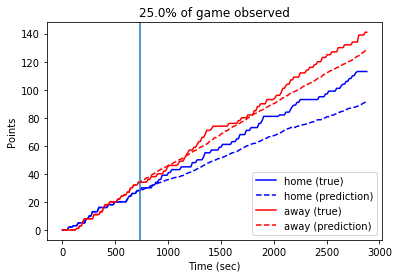

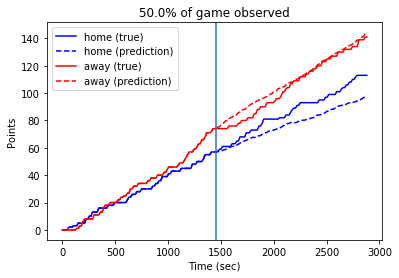

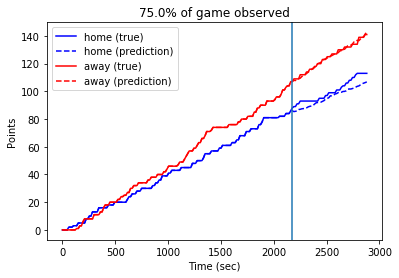

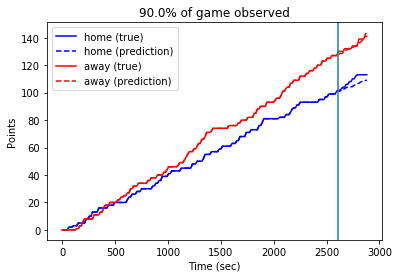

In [53]:
y_true_home = target_home_list[0][target_id].rename(lambda x: x * 15)
y_true_away = target_away_list[0][target_id].rename(lambda x: x * 15)

for k in range(1, 5):
    y_pred_home = df_pred_home.iloc[k,:]
    y_pred_away = df_pred_away.iloc[k,:]
    
    y_pred_home = y_pred_home.rename(lambda x: x * 15)
    y_pred_away = y_pred_away.rename(lambda x: x * 15)
    
    plt.plot(y_true_home[0:193], color="blue")
    plt.plot(y_pred_home[0:193], color="blue", linestyle='dashed')
    plt.plot(y_true_away[0:193], color="red")
    plt.plot(y_pred_away[0:193], color="red", linestyle='dashed')
    plt.xlabel("Time (sec)")
    plt.ylabel("Points")
    plt.axvline(x=T_0s[k]*15)
    plt.legend(["home (true)","home (prediction)", "away (true)", "away (prediction)"])
    plt.title("{}% of game observed".format(train_pcts[k]*100))
    plt.show()

In [985]:
# Saeyoung code
print(target_id)
for T_0 in T_0s:
    mRSC_home.learn(target_id, T_0, method='lr')
    mRSC_away.learn(target_id, T_0, method='lr')

21700100


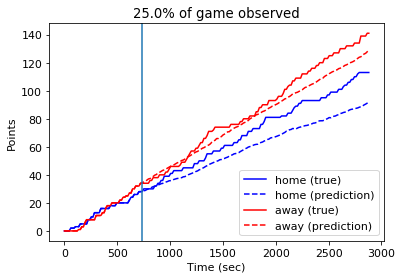

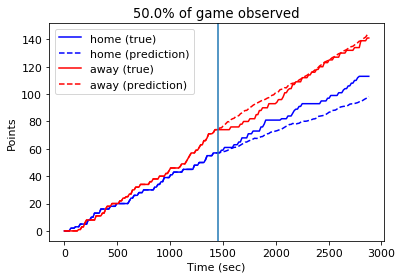

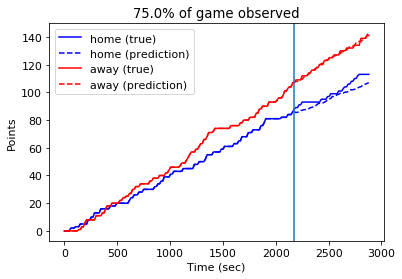

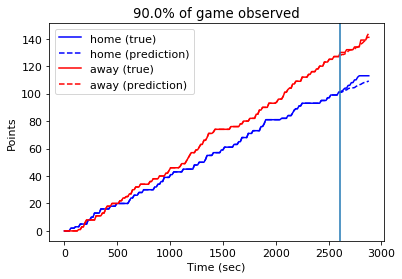

In [1004]:
y_true_home = target_home_list[0][target_id].rename(lambda x: x * 15)
y_true_away = target_away_list[0][target_id].rename(lambda x: x * 15)

for k in range(1, 5):
    y_pred_home = df_pred.iloc[k,:]
    y_pred_away = df_pred_away.iloc[k,:]
    
    y_pred_home = mRSC_home.pred[k].iloc[mRSC_home.pred[k].index == target_id,:T].T.reset_index(drop=True).rename(lambda x: x * 15)
    y_pred_away = mRSC_away.pred[k].iloc[mRSC_away.pred[k].index == target_id,:T].T.reset_index(drop=True).rename(lambda x: x * 15)
    
    plt.plot(y_true_home[0:193], color="blue")
    plt.plot(y_pred_home[0:193], color="blue", linestyle='dashed')
    plt.plot(y_true_away[0:193], color="red")
    plt.plot(y_pred_away[0:193], color="red", linestyle='dashed')
    plt.xlabel("Time (sec)")
    plt.ylabel("Points")
    plt.axvline(x=T_0s[k]*15)
    plt.legend(["home (true)","home (prediction)", "away (true)", "away (prediction)"])
    plt.title("{}% of game observed".format(train_pcts[k]*100))
    plt.show()